# ASTR 21100 

# "Computational Techniques in Astrophysics"

## Instructor: Andrey Kravtsov

### office: ERC 415; email: kravtsov@uchicago.edu
### office hours: Tue, 10:30am-noon (unless noted otherwise)

#### Teaching Assistants: 
#### Dimitrios Tanoglidis (dtanoglidis@uchicaago.edu)
#### Georgios Zakharegkas (gzakharegkas@uchicago.edu)

In [39]:
# preliminary setup

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
# allow automatic reload of imported codes, if they are modified
%load_ext autoreload
%autoreload 2

from codes.plot_utils import plot_pretty
plot_pretty(150, fontsize=12)

fsize=5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Introduction to machine learning methods

Two main categories in how these methods employ data sets:

1. Unsupervised learning methods
2. Supervised learning methods

More useful classification is by the application area of each method: for example, see <a href="https://scikit-learn.org/stable/index.html">scikit-learn site front page</a>

Significant fraction of the code examples below uses <a href="http://scikit-learn.org/stable/">scikit-learn</a> library. So please install it, before you run. it should be as easy as

    pip install scikit-learn

You can find more detailed installation instructions <a href="http://scikit-learn.org/stable/install.html">here.</a>

Finding clusters in data is one of the most frequent machine learning method classes used in practice. 

Example, k-means clustering routine below is adopted and modified from the <a href="https://github.com/dstndstn/Unsupervised">tutorial for unsupervised machine learning methods</a> by <a href="http://dstn.astrometry.net/">Dustin Lang.</a>


### Clustering methods

Clustering is used to explore structure in the data and use such information to classify data, for example. There are many clustering algorithms, in particular those that are designed to work in $\leq 3$ dimensions. 

However, finding neighbors becomes progressively more difficult with increasing number of dimensions. 


The clustering methods rely on efficient way of finding neighbors usually (see <a href="08b_neighbor_search_methods.ipynb"><tt>08b_neighbor_search_methods.ipynb</tt></a> notebook for intro into neighbor search algorithms).

Below we will consider the algorithm that works reasonably well in large number of dimensions, which does not rely on the neighbor search. 


### K-means clustering algorithm

K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.
*Expectation-Maximization* is a two-step approach which works as follows:

Specify the number, $K$, of clusters and guesses for their centers, $\mu_k$, on input. Then perform the following steps iteratively until convergence. 

1. Assign points to the nearest cluster center, i.e. the cluster with minimum of $d(\vec{x}_i)=\mathrm{arg min}_k \vert\vert \vec{x}_i-\vec{\mu}_k\vert\vert$, where $\vert\vert\cdot\vert\vert$ is a suitably defined distance (such as Eucledian distance). 
2. Set the cluster centers to the mean of the points assigned to them: $\vec{\mu}_k = 1/N_k\sum_{i\in C_k} \vec{x}_i$. Repeat 1.

In [40]:
def distance_matrix(A, B):
    '''
    Given two sets of data points, computes the Euclidean distances
    between each pair of points.

    *A*: (N, D) array of data points
    *B*: (M, D) array of data points

    Returns: (N, M) array of Euclidean distances between points.
    '''
    Na, D = A.shape
    Nb, Db = B.shape
    assert(Db == D)
    dists = np.zeros((Na,Nb))
    for a in range(Na):
        dists[a,:] = np.sqrt(np.sum((A[a] - B)**2, axis=1))
    return dists


In [41]:
def sample_D_gaussian(mean, covar, N, D):
    """
    sample N numbers from a Gaussian in D dimensions
    mean = vector of mean values
    covar = matrix of covariances
    """
    if np.isscalar(covar):
        # assume isotropic
        return np.random.normal(loc=mean, scale=np.sqrt(covar), size=(N,D))
    # otherwise use covariance matrix
    covar = np.array(covar)
    u, s, v = np.linalg.svd(covar)
    # generate a usual Gaussian
    x = np.random.normal(size = (N,D))
    # rotate it according to align with the covariance matrix
    return mean + np.dot(u, (x * s).T).T


In [42]:
def k_means(X, K, diagnostics=None):
    '''
    K-means clustering algorithm.
    
    *X*: (N, D) array of data points
    *K*: integer number of clusters to find
    *diagnostics*: optional function to run each round:
        diagnostic(step, X, K, centroids, newcentroids, nearest)

    Returns: *centroids*: (K,D) array of cluster centroids
    '''

    N,D = X.shape
    
    # Initialize randomly: draw K integers (no duplicates)
    # using permutation() is overkill, but easy
    I = np.random.permutation(N)[:K]
    centroids = X[I]

    # Loop until convergence... or 20 steps in case you mess up!
    for step in range(20):
        # Compute the distance from each data point in X
        # to each cluster centroid.
        distances = distance_matrix(X, centroids)
        # 'distances' has shape (N, K)
        
        # Find the nearest cluster centroid for each data point
        nearest = np.argmin(distances, axis=1)
        # 'nearest' has shape (N)

        # Compute the new centroids... they will go in this array:
        newcentroids = np.zeros((K, D))
        
        # new centroid for cluster k is the mean of all
        # the data points that are nearest to the current cluster k.
        for k in range(K):
            I = np.flatnonzero(nearest == k)
            newcentroids[k,:] = np.mean(X[I,:], axis=0)
        
        # Note:
        # data point i is at x,y = (X[i,0], X[i,1]) and is closest
        # to cluster centroid index nearest[i].
        
        # Make diagnostic plot for this round?
        if diagnostics is not None:
            diagnostics(step, X, K, centroids, newcentroids, nearest)

        # Are we converged?  This is a hacky test.
        if np.max(np.abs(newcentroids - centroids)) < 1e-8:
            centroids = newcentroids
            break

        centroids = newcentroids

    return centroids


In [43]:
# generate a mock data set with 3 well-separated clusters of Gaussian point density distribution in 2D

amps = [0.6, 0.2, 0.2]
means = [ (3., 4.), (7., 9.), (10.5, 4.) ]
covs = [ np.array([[1.,-0.5],[-0.5,1.]]),
         np.array([[1., 0.], [0., 1.]]),
         np.array([[1.,0.5],[0.5,1.]]) ]

N = 1000

# number of points in each cluster
ncl = np.random.multinomial(N, amps)
x = []
x.append(sample_D_gaussian(means[0], covs[0], ncl[0], 2))
x.append(sample_D_gaussian(means[1], covs[1], ncl[1], 2))
x.append(sample_D_gaussian(means[2], covs[2], ncl[2], 2))



In [74]:
# this is how they look like
colors = 'brgmck'

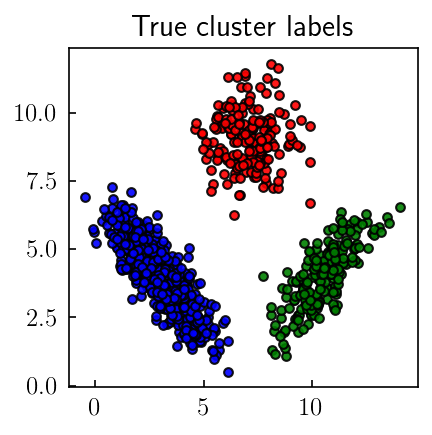

In [44]:
plt.figure(figsize=(3,3))
for i, xd in enumerate(x):
    plt.scatter(xd[:,0], xd[:,1], marker='.', s=70.0, 
                edgecolor='black', alpha=0.9, c=colors[i])
plt.title('True cluster labels');
plt.show();


Let's run K-means routine to identify clusters. It should be run and identified clusters examined several times to see how results fluctuate.  

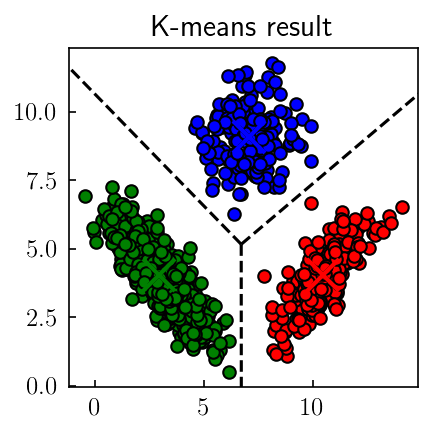

In [76]:
from codes.plot_utils import plot_kmeans

K = 3
X = np.vstack(x)
centroids = k_means(X, K)

plt.figure(figsize=(3,3))
plot_kmeans(0, X, K, centroids, centroids, None, show=False)
plt.title('K-means result');

Now let's repeat this with the <tt>KMeans</tt> routine implementing the K-means clustering algorithm in scikit-learn package. 

Wall time: 17.1 ms


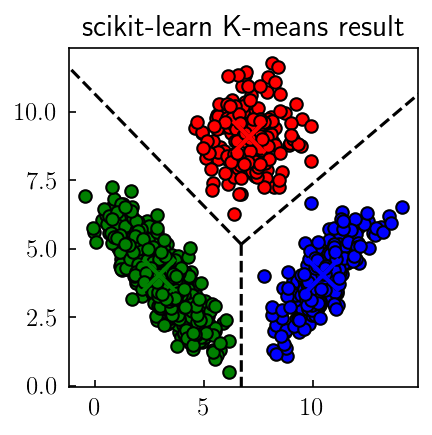

In [77]:
from sklearn.cluster import KMeans

model = KMeans(K)
%time labels = model.fit_predict(X)

plt.figure(figsize=(3,3))
centroids = model.cluster_centers_
plot_kmeans(0, X, K, centroids, centroids, None, show=False)
plt.title('scikit-learn K-means result');

The results of the scikit-learn routine do not fluctuate. This is because they explore a range of initial guesses for cluster centers, and choose the most frequent result out of this range. Even so, we can see that the scikit-learn routine is faster than implementation above.  So I will use it for more computationally intensive tasks below. 

### KMeans Caveats

The convergence of this algorithm is not guaranteed; for that reason, implementation in scikit-learn by default uses a large number of random initializations and finds the best results.

Also, the number of clusters must be set beforehand... there are other clustering algorithms for which this requirement may be lifted.

### A more realistic example: classification of globular clusters

Let's examine, whether we can easily see putative low- and high-metallicity cluster populations, frequently discussed in the literature, in the plane of metallicity $[Fe/H]$ and V-band absolute magnitude, $M_V$, using Milky Way globular clusters in the William Harris's <a href="http://physwww.mcmaster.ca/~harris/mwgc.dat">catalog</a>. The data file (with GCs without metallicities or absolute magnitudes removed) is added in <tt>data/gcz.dat</tt> in the repository. 


In [79]:
# read V-band absolute magnitude and metallicity ([Fe/H]) of the Milky Way GCs
X_GC = np.loadtxt('data/gcz.dat', usecols=(1,7), unpack=True)
X = X_GC.T

Wall time: 15 ms


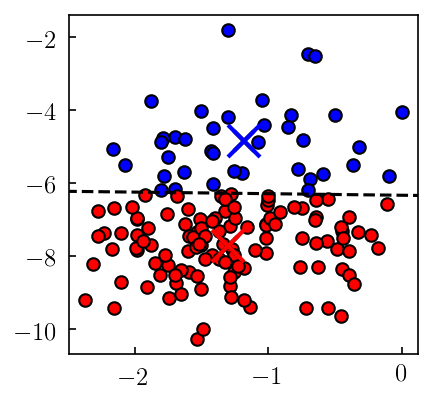

In [80]:
K = 2
model = KMeans(K)

%time labels = model.fit_predict(X)

plt.figure(figsize=(3,3))
centroids = model.cluster_centers_
plot_kmeans(0, X, K, centroids, centroids, None, show=False)

If there are clusters in this distribution, they are not obvious. If anything the K-means algorithm identifies clusters in the y-axis (absolute magnitude), not in metallicity. Yet, one often reads and hears about "metallicity-rich" and "metallicity poor" populations of globular clusters. Clustering analysis shows no evidence for such populations in this 2D parameter space, similarly to our conclusion in considering 1D distribution of metallicities using histogram with objectively determined number of bins (see ex16 notebook).  

### Applying K-means cluster finder to galaxy $g-r$ color distribution


In [50]:
from astropy.io import fits

hdulist = fits.open('data/sdss_galaxies.fits') 

# data table in the FITS is a dictionary, which we will convert to the numpy dictionary (record)
data = np.asarray(hdulist[1].data)

In [70]:
zmin, zmax = 0.1, 0.14
rmin, rmax = 17, 17.77
isel = ((data['r'] > rmin) & (data['r'] < rmax) & (data['z'] > zmin) & (data['z'] < zmax))

In [81]:
# g-r color of all galaxies in the selected subsample
gr = data['g'][isel] - data['r'][isel]
mr = data['r'][isel]
X = np.vstack((mr, gr))
X = X.T

Wall time: 137 ms


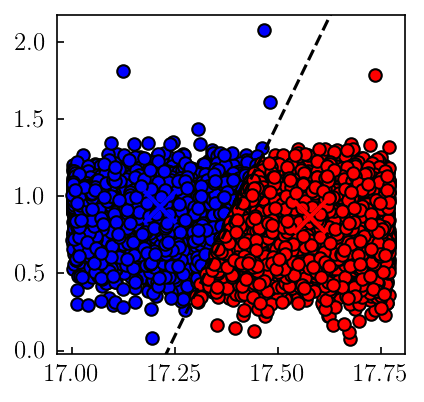

In [82]:
K = 2
model = KMeans(K)

%time labels = model.fit_predict(X)

plt.figure(figsize=(3,3))
centroids = model.cluster_centers_
plot_kmeans(0, X, K, centroids, centroids, None, show=False)

### Gaussian-mixture modeling and extreme deconvolution

K-means clustering fails when clusters overlap (this becomes less and less of an issue as the number of dimensions increases).

Let's generate mock clusters that are closer together and thus overlap more. 

In [83]:
amps = [0.6, 0.2, 0.2]
means = [ (3., 4.), (7., 9.), (6.5, 4.) ]
covs = [ np.array([[1.,-0.5],[-0.5,1.]]),
         np.array([[1., 0.], [0., 1.]]),
         np.array([[1.,0.5],[0.5,1.]]) ]

N = 1000

# number of points in each cluster
ncl = np.random.multinomial(N, amps)
x = []
x.append(sample_D_gaussian(means[0], covs[0], ncl[0], 2))
x.append(sample_D_gaussian(means[1], covs[1], ncl[1], 2))
x.append(sample_D_gaussian(means[2], covs[2], ncl[2], 2))


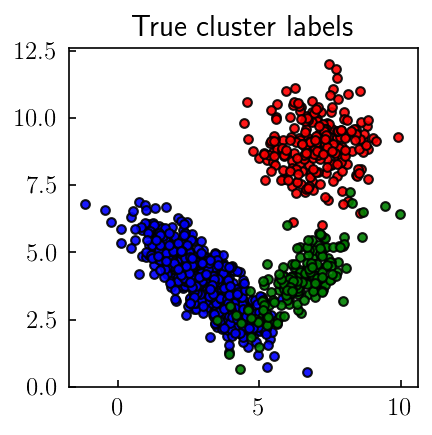

In [84]:
plt.figure(figsize=(3,3))

for i, xd in enumerate(x):
    plt.scatter(xd[:,0], xd[:,1], marker='.', s=70.0, edgecolor='black', alpha=0.9, c=colors[i])
plt.title('True cluster labels');
plt.show();


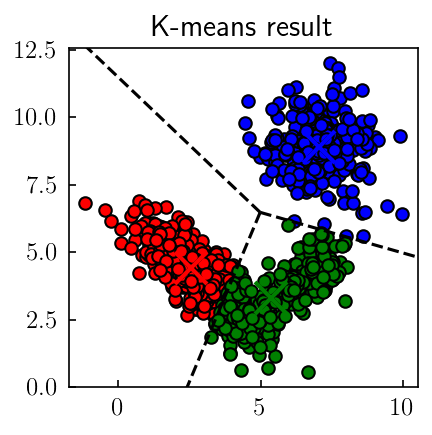

In [85]:
K = 3
X = np.vstack(x)
centroids = k_means(X, K)

plt.figure(figsize=(3,3))
plot_kmeans(0, X, K, centroids, centroids, None, show=False)
plt.title('K-means result');

We can see that in this case, K-means is not doing a very good job, because different clusters overlap. 

More subtle methods that can handle overlap of clusters and can assign probabilities to belong in each cluster are needed. This can be done using the Gaussian mixture model (GMM). When points on which Gaussian mixture model is constructed have uncertainties associated with them the method of inference of the Gaussians is called <i>extreme deconvolution</i>. 



### The Gaussian Mixture Model (GMM)

The Gaussian mixture models (GMM) are computed with the *expectation maximization (EM) algorithm.* This algorithm applies not for the GMM, but generally for likelihood maximization (or any function maximization) problem (see <a href="https://arxiv.org/abs/1105.1476">Roche 2011</a> for a more in-depth introduction to the algorithm and its variants). 


The probability of a point $x_i$ in multi-D space is modelled with a Gaussian mixture (a sum of Gaussian probabilities) as: 

$$p(\vec{x}_i|\vec{\theta}) = \sum\limits_{j=1}^{M}\alpha_j\mathcal{N}(\vec{\mu}_j,\sigma_j),$$

where $\vec{\theta}$ contains parameters of all the Gaussian pdfs in the mixture to be estimated. $M$ is the number of Gaussians specified as input, $\vec{\mu}_j$ and $\sigma_j$ are the mean and covariance matrix of each Gaussian.  



The key assumption of the EM algorithm is that for each data point we know probability, $p(j\vert \vec{x}_i)$ that it belongs to a certain cluster (or class) $j$. This does not actually have to be assumed when algorithm is used, but the algorithm is derived under such assumption. 

The log-likelihood for $M$ Gaussians fitting $N$ data points is 

$$
\ln L = \sum\limits_{i=1}^N\ln\left[\sum\limits_{j=1}^M\alpha_j p_j(\vec{x}_i\vert\vec{\theta})\right]
$$

Setting its partial derivatives with respect to $\theta_j$ components ($\mu_j$ and $\sigma_j$) in 1D, and requiring that the sum of probabilities of all classes sums to 1, can be shown to give the following equations for $\mu_j$, $\sigma_j$ and $\alpha_j$:


$$\vec{\mu}_j = \frac{\sum\limits_{i=1}^N w_{ij}\vec{x}_i}{\sum\limits_{i=1}^N w_{ij}};\ \ \ \sigma_j^2 = \frac{\sum\limits_{i=1}^N w_{ij}(\vec{x}_i-\vec{\mu}_j)^2}{\sum\limits_{i=1}^N w_{ij}}$$

$$\alpha_j = \frac{1}{N}\sum\limits_{i=1}^N w_{ij}.$$

Then, algorithm starts with random guesses for probability for point $i$ to be in $j$-th Gaussian $w_{ij}$ for each data point $i$ and then repetiton of the maximization (M) and expectation (E) steps until convergence. 

* M: compute $\mu_j$, $\sigma_j^2$, and $\alpha_j$ using equations above.

* E: recompute $w_{ij}$ as class probability

$$w_{ij} = \frac{\alpha_j\mathcal{N}(x_i,\mu_j,\sigma_j)}{\sum\limits_{i=1}^N \alpha_j\mathcal{N}(x_i,\mu_j,\sigma_j) }. $$

This algorithm is implemented in the routine <tt>em_gmm</tt> below. 

In [86]:
def plot_ellipse(mean, cov, *args, **kwargs):
    import pylab as plt
    u,s,v = np.linalg.svd(cov)
    angle = np.linspace(0., 2.*np.pi, 200)
    u1 = u[0,:]
    u2 = u[1,:]
    s1,s2 = np.sqrt(s)
    xy = (u1[np.newaxis,:] * s1 * np.cos(angle)[:,np.newaxis] +
          u2[np.newaxis,:] * s2 * np.sin(angle)[:,np.newaxis])
    return plt.plot(mean[0] + xy[:,0], mean[1] + xy[:,1], *args, **kwargs)
    
    
def plot_em(step, X, K, amps, means, covs, z,
            newamps, newmeans, newcovs, show=True):
    import pylab as plt
    from matplotlib.colors import ColorConverter

    (N,D) = X.shape

    if z is None:
        z = np.zeros((N,K))
        for k,(amp,mean,cov) in enumerate(zip(amps, means, covs)):
            z[:,k] = amp * gaussian_probability(X, mean, cov)
        z /= np.sum(z, axis=1)[:,np.newaxis]
    
    plt.clf()
    # snazzy color coding
    cc = np.zeros((N,3))
    CC = ColorConverter()
    for k in range(K):
        rgb = np.array(CC.to_rgb(colors[k]))
        cc += z[:,k][:,np.newaxis] * rgb[np.newaxis,:]

    plt.scatter(X[:,0], X[:,1], color=cc, s=9, alpha=0.5)

    ax = plt.axis()
    for k,(amp,mean,cov) in enumerate(zip(amps, means, covs)):
        plot_ellipse(mean, cov, 'k-', lw=4)
        plot_ellipse(mean, cov, 'k-', color=colors[k], lw=2)

    plt.axis(ax)
    if show:
        plt.show()


In [87]:
def gaussian_probability(X, mean, cov):
    '''
    Returns the probability of drawing data points from a Gaussian distribution

    *X*: (N,D) array of data points
    *mean*: (D,) vector: mean of the Gaussian
    *cov*: (D,D) array: covariance of the Gaussian

    Returns: (N,) vector of Gaussian probabilities
    '''
    D,d = cov.shape
    assert(D == d)

    # I haven't found a beautiful way of writing this in numpy...
    mahal = np.sum(np.dot(np.linalg.inv(cov), (X - mean).T).T * (X - mean),
                   axis=1)
    return (1./((2.*np.pi)**(D/2.) * np.sqrt(np.linalg.det(cov)))
            * np.exp(-0.5 * mahal))


In [88]:
# Here is an implementation of the Expectation-Maximization algorithm for 
# Gaussian Mixture Models.

def em_gmm(X, K, diagnostics=None):
    '''
    Expectation-Maximization (E-M) for Gaussian Mixture Models

    *X*: (N,D) data points
    *K*: integer number of components
    
    Returns: a list of K tuples of (amps, means, covariances)
    of the Gaussian components
    '''
    N,D = X.shape
    
    # Random initialization (scaled by dataset standard deviation)
    amps = np.ones(K) / K
    std = np.std(X, axis=0)
    means = np.random.normal(loc=np.mean(X), scale=std, size=(K,D))
    covs = [np.diag(std) for k in range(K)]

    # Until convergence... this can take many iterations
    for step in range(25):
        # Compute the "indicator" variable z[i,k]: probability that data
        # point i was drawn from Gaussian component k.
        z = np.zeros((N,K))

        for k,(amp,mean,cov) in enumerate(zip(amps, means, covs)):
            #print 'Component K: amp', amp, 'mean', mean, 'cov', cov
            z[:,k] = amp * gaussian_probability(X, mean, cov)
    
        # Normalize the indicator over *components* --
        # ("this data point had to come from somewhere")
        z /= np.sum(z, axis=1)[:,np.newaxis]

        # You might want to check out the equations here:
        # http://dstn.astrometry.net/talks/2015-06-03-phat-michigan-p18.pdf

        newamps = np.sum(z, axis=0)
        newamps /= np.sum(newamps)
        newmeans = [np.sum(z[:,k][:,np.newaxis] * X, axis=0) / np.sum(z[:,k])
                    for k in range(K)]
        newcovs = [np.dot((X - mean).T, z[:,k][:,np.newaxis] * (X - mean)) / np.sum(z[:,k])
                   for k,mean in enumerate(means)]

        # You could also write it more explicitly:
        #newamps = np.sum(z, axis=0)
        #newamps /= np.sum(newamps)
        #
        #newmeans = np.zeros((K,D))
        #for k in range(K):
        #    zk = z[:,k]
        #    for d in range(D):
        #        newmeans[k,d] = np.sum(zk * X[:,d]) / np.sum(zk)

        #newcovs = np.zeros((K,D,D))
        #for k,mean in enumerate(means):
        #    zk = z[:,k]
        #    newcovs[k,:,:] = np.dot(zk * (X - mean).T, (X - mean)) / np.sum(zk)

        if diagnostics is not None:
            diagnostics(step, X, K, amps, means, covs, z,
                        newamps, newmeans, newcovs)
            
        amps, means, covs = newamps, newmeans, newcovs

    return amps, means, covs

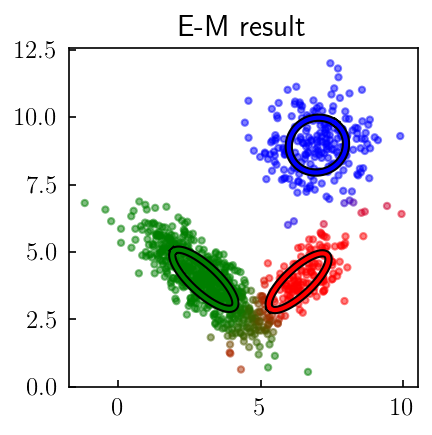

In [89]:
K = 3

amps,means,covs = em_gmm(X, K)

# Plot the final fit
plt.figure(figsize=(3,3))
plot_em(0, X, K, amps, means, covs, None, None, None, None,
              show=False)
plt.title('E-M result');

In this case the points are colored with probability to belong to each of the Gaussian components and you can see that the algorithm allows overlap of clusters and handles it quite well. 

The number of Gaussian components can be determined using estimates of the Bayes factors or the Bayesian Information Criterion (BIC) approximation, i.e. performing model comparison for models with $N$ and $N+1$ Gaussian components. If the $N+1$ is not "better" according to some threshold, stop at $N$ components. 

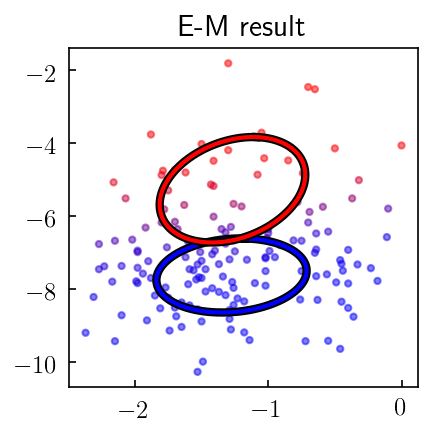

In [90]:
K = 2

X = X_GC.T
amps,means,covs = em_gmm(X, K)

# Plot the final fit
plt.figure(figsize=(3,3))
plot_em(0, X, K, amps, means, covs, None, None, None, None,
              show=False)
plt.title('E-M result');

### How to decide how many components there should be?

For $K$-means there is no good way to do this automatically. For the GMM there is. 

Given that GMM is based on the likelihood, we could use standard model comparison techniques to compare models with different number of components $M$. If this is too expensive to do, often a shortcut is used when instead of proper estimation of $\chi^2$ or evidence, *Bayesian Information Criterion* (BIC) is used: 

$$\mathrm{BIC} = -2\ln L^{\rm max} + k\ln N,$$

where $L^{\rm max}$ is the maximum value of the likelihood among the positions of all $N$ data points, $k$ is the number of parameters in the model. 

BIC is the Bayesian evidence under assumptions that: 

1) posterior is Gaussian

2) width of the posterior for all parameters scale as $\sigma\approx c/\sqrt{N}$ 

3) prior in all parameters is flat $p\propto \Delta$ and $c/\Delta\sim 1$. 

**Exercise.** I will leave it as an exercise to you to compute BICs for 1, 2, 3 components for the GCs in the example above.

### Another example of clustering application:  image compression with the K-means clustering algorithm

K-means clustering can be applied in practice to greatly compress the number of colors used in an image without a noticeable visual loss of image quality.
    

 The example is inspired by a similar example in Jake van der Plas's <a href="https://github.com/jakevdp/sklearn_pycon2015">introduction to scikit-learn package</a>. 

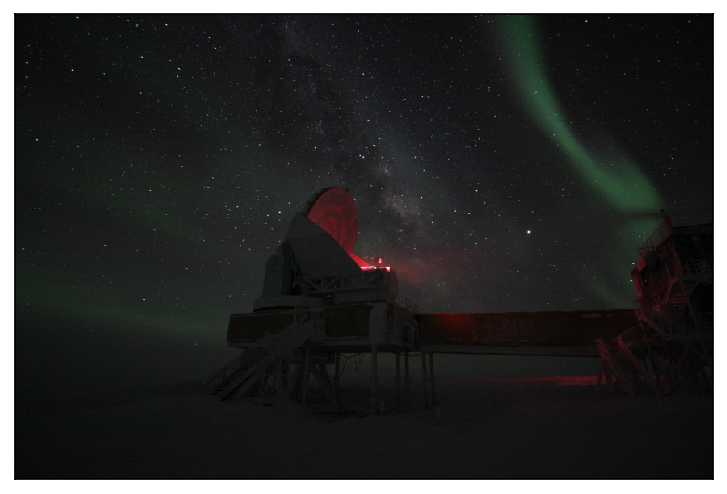

In [21]:
# load SPT at night image as numpy array
#img = np.asarray(Image.open(data_home_dir()+"SPT_stars_dana_working_vanderlinde.JPEG"))
from skimage import io
img = io.imread('img/SPT_stars_dana_working_vanderlinde.jpeg')

plt.figure(figsize=(6,6))
#plt.imshow(Image.fromarray(img.astype(np.uint8)))
plt.imshow(img);
plt.xticks(()); plt.yticks(())
plt.show()

The red, green and blue use 8 bits each, which have integer values from 0 to 255. This makes 256*256*256=16777216 possible colors

In [22]:
def n_unique_image_colors(image):
    img_colors = image[:,:,0]*65536 + image[:,:,1]*256 + image[:,:,2]
    return np.shape(np.unique(img_colors))

In [23]:
print(np.shape(img))

print(n_unique_image_colors(img))

(576, 864, 3)
(9607,)


Thus, the above image contains 9607 colors! It's clear however that they must mostly be shades of black and so there is room for color compression. We can think of the image colors as points in 3D R, G, B space and can find a given number of color clusters in that space to identify similar colors and get rid of subtle color variations within each cluster by substituting colors in each cluster by the cluster mean color. 

Running the code below takes a while...

In [24]:
from sklearn.cluster import KMeans

# reduce the size of the image for speed
image = img # could be use for speed testing to select every other pixel [::2, ::2]
n_colors = 64

X = image.reshape(-1, 3)

model = KMeans(n_colors)
%time labels = model.fit_predict(X)
img_colors = model.cluster_centers_
new_image = img_colors[labels].reshape(image.shape)


Wall time: 3min 57s


In [25]:
print("the number of unique colors in the new_image is %d"%n_unique_image_colors(new_image))

the number of unique colors in the new_image is 64


Text(0.5, 1.0, '64 colors')

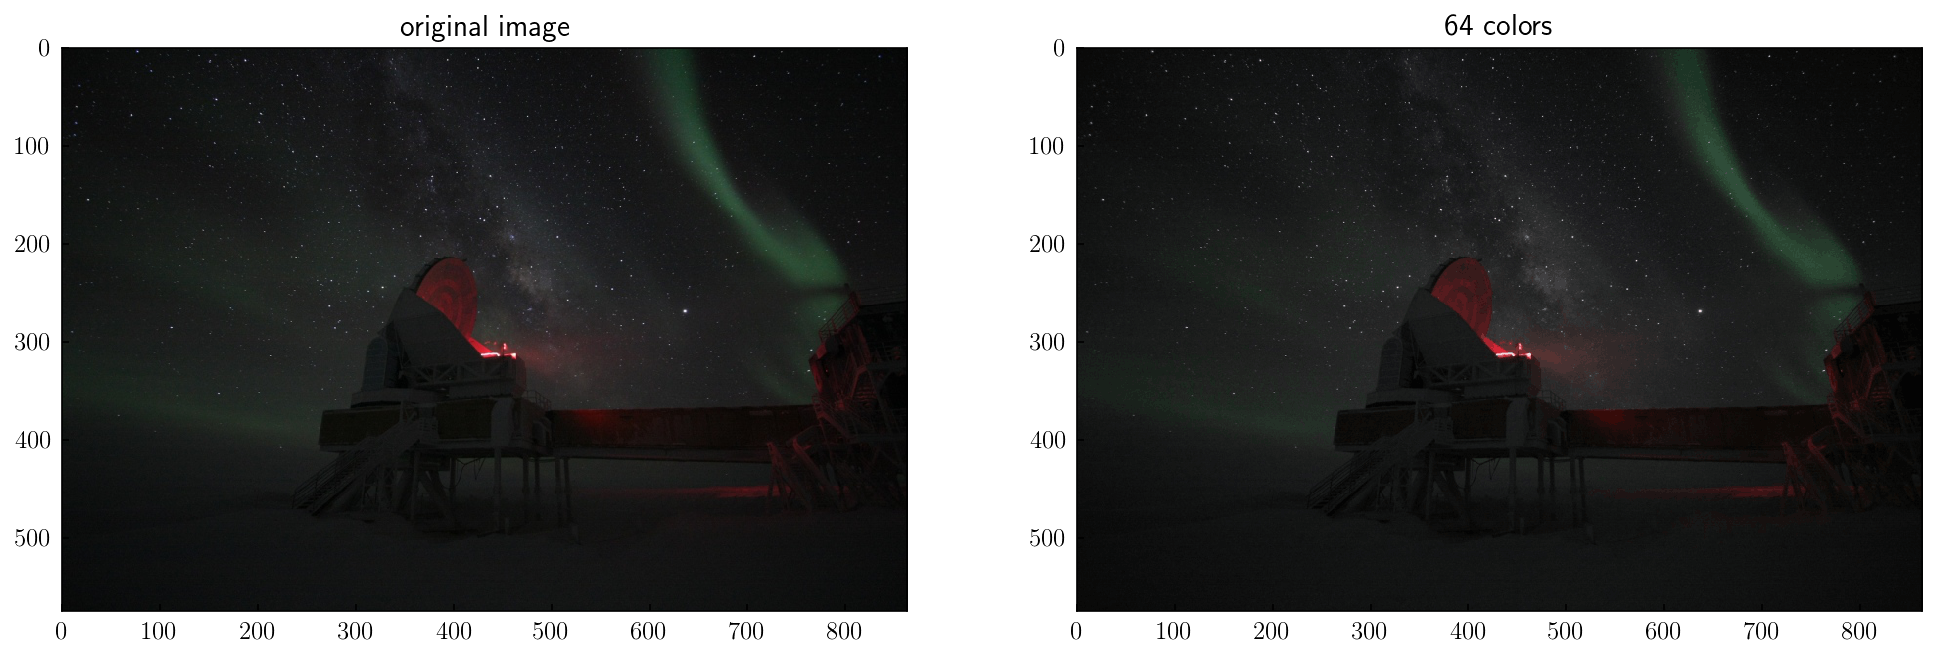

In [26]:
_, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].imshow(img)
ax[0].set_title('original image')

new_image = new_image.astype(np.uint8)
ax[1].imshow(new_image)
ax[1].set_title('{0} colors'.format(n_colors))

These images are very much alike visually, even on a good screen and zoomed-in, but the right one uses almost 200 times fewer colors. 

This is an illustration of what machine learning is about. In this instance - unsupervised learning. The algorithm knew nothing about the image beforehand. It went and <i>"learned"</i> the structure in the image color space and <i>automatically</i> identified a user-specified number of color clusters in R, G, B space (i.e. clusters of pixels of similar cloud). We do not actually know (at least not without additional investigation) what those color clusters are or how they look like in the color space, we just had a hunch from looking at the original image that the number of clusters should be fairly small (definitely much smaller than $10^4$ original colors).   

### Reading:

* <a href="https://www.datascience.com/blog/k-means-clustering">introduction</a> to the $K$-means clustering algorithm 

* <a href="https://arxiv.org/abs/1105.1476">Roche 2011</a> for a short introduction/tutorial for expectation-maximization algorithm. 


### Classification with machine learning methods: 
### hand-written digits recognition 


<a href=" http://yann.lecun.com/exdb/mnist/index.html">MNIST hand-written digits database</a> consists of 70000 28x28=784 pixel gray-scale images of hand-written digits from 0 to 9. The images are stored in the data field while target field stores the correct digit identifier. The problem of classifying the images is a problem of finding the regions occupied by each digit in all of its hand-written variations in the 784-dimensional space. 

Let's read it in.

In [95]:
from sklearn.metrics import accuracy_score

# uncomment to download MNIST hand-written image data
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
mnist_digits = fetch_openml('mnist_784')
# Load data from https://www.openml.org/d/554
#mnist_digits, y = fetch_openml('mnist_784', version=1, return_X_y=True)


In [27]:
print("dimensions of MNIST data set:",np.shape(mnist_digits.data))
#print("unique entries in the data set:",np.unique(mnist_digits.target))
print("unique entries in the data set:",np.unique(y))

dimensions of MNIST data set: (70000, 784)
unique entries in the data set: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [11]:
def show_random_digits(nshow=10, figsize=(20,2)):
    _, axs = plt.subplots(1, nshow, figsize=(20,2))
    #generate nshow random image numbers
    ir = np.random.randint(np.shape(mnist_digits.data)[0], size=nshow)
    # display these random images
    for i, ax in enumerate(axs):
        ax.imshow((mnist_digits.data[ir[i]].reshape(28,28)), cmap=plt.cm.binary)
        ax.set_xticks(()); ax.set_yticks(())
    
    plt.show()

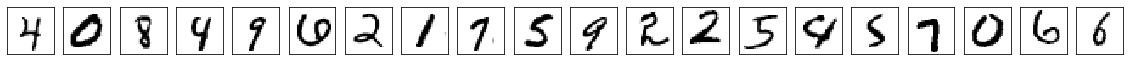

In [12]:
show_random_digits(nshow=20)


### K-means clustering

Below we run the K-means clustering algorithm on the training data set extracted from MNIST assuming different number of clusters. 10 clusters seems like a natural number to use here, but it turns out that some of the digits overlap in the 784-d space and using more clusters provides more accurate results. The cell below takes a while to run, as we are performing clustering on a significant number of points. 

In [91]:
from sklearn.cluster import KMeans
from timeit import default_timer

est = []; clusters = []
#n_cls = [10, 20, 100]; 
n_cls = [5, 10, 20]; 
kmeans_times = []
for n_cl in n_cls:
    tstart = default_timer()
    estd = KMeans(n_clusters=n_cl)
    est.append(estd)
    clusters.append(estd.fit_predict(mnist_digits.data))
    tend = default_timer()
    kmeans_times.append(tend-tstart)
    print("K-means for n_cl = %d clusters took %.2f sec"%(n_cl, tend-tstart))


K-means for n_cl = 5 clusters took 81.49 sec
K-means for n_cl = 10 clusters took 245.76 sec
K-means for n_cl = 20 clusters took 264.80 sec


In [ ]:
from scipy.stats import mode

labels = np.zeros_like(np.array(clusters))
for icl, n_cl in enumerate(n_cls):
    for i in range(n_cl):
        mask = (clusters[icl] == i)
        labels[icl,mask] = mode(mnist_digits.target[mask])[0]


In [ ]:
print("accuracy of the K-means classification of MNIST hand-written digits: %s"%' ')
for icl, n_cl in enumerate(n_cls):
    print("   for %d clusters accuracy is %.3f"%(n_cl, 
                                                 accuracy_score(mnist_digits.target.astype(int), labels[icl])))

n_clusters=5
[1 3 1 7 7 6 7 6 1 1 7 7 7 0 6 1 3 1 6 7 3 1 3 6 1 7 7 3 6 3]
n_clusters=10
[1 8 8 4 4 6 7 6 1 1 7 7 7 0 6 1 3 4 2 4 3 1 8 6 1 7 4 8 6 3]
correct digits:
[1 8 8 4 7 6 7 2 2 1 9 9 7 0 6 1 8 2 2 4 5 1 8 6 1 4 4 5 6 5]


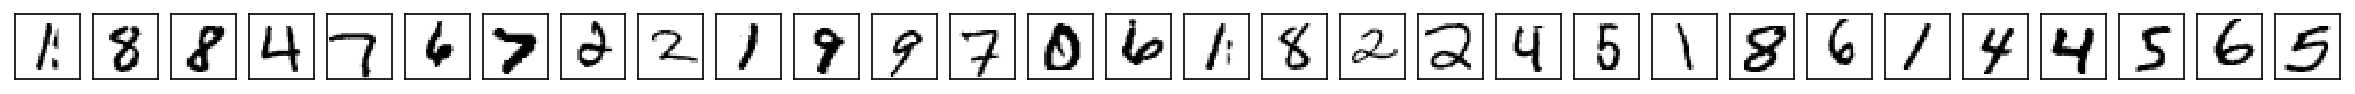

In [44]:
nshow = 30
_, axs = plt.subplots(1, nshow, figsize=(20,2))

ir = np.random.randint(np.shape(mnist_digits.data)[0], size=nshow)
for i, ax in enumerate(axs):
    ax.imshow((mnist_digits.data[ir[i]].reshape(28,28)), cmap=plt.cm.binary)
    ax.set_xticks(()); ax.set_yticks(())
    #kmeans_output = labels[i]

for icl, n_cl in enumerate(n_cls):
    print("n_clusters=%d"%(n_cl))
    print(labels[icl][ir])

print("correct digits:")
print(np.array(mnist_digits.target[ir]).astype(int))

plt.show()

We can see that it takes progressively longer for more clusters and results do improve, but improvement from 100 to 200 clusters is only 3%. For large number of clusters the accuracy of the method saturates. Although, accuracy of 90-95% on this problem is not bad, both the execution time and the accuracy are not competitive with more sophisticated supervised learning algorithms for this problem. 

Moreover, we obtained these accuracy scores on the same samples we did the clustering on. This is not quite right. To test a method, we need to try it on some new data. Thus, the concepts of "training data" and "test data". Additionally, "cross-validation data" sample is used to choose *hyper-parameters* of an algorithm. 

**Exercise.** As a possible exercise, write a code to carry out Gaussian Mixture analysis and use BIC to determine the optimal number of components (clusters).

### Supervised classification algorithms

Let's now repeat this with a few different supervised machine learning methods. 
Supervised algorithm require a training set, for which class (cluster) labels are specified. The 
test data set is then used to estimate how accurately class labels can be predicted for data that was not used in training. 

Note that digits in the MNIST database are ordered, so we will define the training sample to be ntrain randomly drawn entries from it.  

In [31]:
from sklearn.model_selection import train_test_split

# first, normalize
mnist_digits.data = 1.*mnist_digits.data / 255.

# define the size of the training sample, 70000-ntrain will be the test sample
ntrain = 60000;
ftrain = 1.*ntrain/np.shape(mnist_digits.data)[0]

# select a random sub-sample of size ntrain for training without replacement (i.e., no duplicates) 
mnist_train, mnist_test, d_train, d_test = train_test_split(mnist_digits.data, mnist_digits.target, 
                                                            test_size = 1.-ftrain, random_state=0)

#### k-th nearest neighbor (knn) algorithm

First, let's consider the k-nearest neigbor algorithm. This algorithm finds k nearest neigbors in the 784-dimensional space of the training sample for a given test sample and returns average result over these neighbors. 

Contribution of each neighbor is weighted inversely proportional to its distance from the test 
sample. Thus, this algorithm identifies class by estimating average class density in a given location using a kernel. It is thus similar to the kernel-density estimate method for regression and density estimation. 


We will use <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">sci-kit learn defaults</a> for this algorithm, which assume $k=5$. 

How do we search for neighbors in such high-$d$ space??? The neighbors can be found using k-d tree, ball tree, or brute force $N^2$ search. These are introduced in the <a href="08b_neighbor_search_methods.ipynb"><tt>08b_neighbor_search_methods.ipynb</tt></a> notebook that is now in the repository. 

In [61]:
from sklearn.neighbors import KNeighborsClassifier

tstart = default_timer()
# define classifier object
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

# train classifier using the training data
knn.fit(mnist_train, d_train)

# predict classes for test data
dpred_knn = knn.predict(mnist_test)
tend = default_timer()
print("Nearest neighbor classifier took %.2f sec"%(tend-tstart))

# estimate classification accuracy of test data using correct answers for it
acc_knn = accuracy_score(d_test, dpred_knn)
print("nearest neighbors accuracy = %.3f "%acc_knn)

Nearest neighbor classifier took 973.31 sec
nearest neighbors accuracy = 0.974 


The execution time is comparable to that of the K-means clustering algorithm for 100 clusters, but the success rate is much higher (97%!). Not bad for such a simple algorithm!

The disadvantage of the k-NN classifier is that it must remember all of the training data and store it for future comparisons with the test data. This may require a lot of memory, if the datasets are large. Also, predicting results for a test image is expensive as the test image needs to be compared to all training images to figure out the closest training images, which are then used to make prediction about the test image. So the method is expensive for large numbers of dimensions arising in image classification with large training set sizes. Although the time is competitive with the k-means clustering, it is not competitive with other machine learning algorithms, such as 

### Support vector machines (SVM)

Linear (i.e. using hyperplanes or hypersurfaces to separate classes) <a href="http://scikit-learn.org/stable/modules/svm.html">support vector machine (SVM)</a> classification algorithm. 

<center>
<img width=500 src="img/Support_vector_machine.jpg"></img>
</center>

In [33]:
from sklearn.svm import LinearSVC

tstart = default_timer()
lsvc = LinearSVC()
lsvc.fit(mnist_train, d_train)
tend = default_timer()
print("Linear SVM took %.2f sec"%(tend-tstart))
d_pred_lsvc = lsvc.predict(mnist_test)

acc_lsvc = accuracy_score(d_test, d_pred_lsvc)
print("Linear SVM accuracy = %.3f"%acc_lsvc)

Linear SVM took 87.50 sec
Linear SVM accuracy = 0.907


C:\Users\h2_sf\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [34]:
from sklearn.svm import SVC

tstart = default_timer()
svc = SVC(gamma='scale')
svc.fit(mnist_train, d_train)
tend = default_timer()
print("SVM took %.2f sec"%(tend-tstart))

d_pred_svc = svc.predict(mnist_test)

acc_svc = accuracy_score(d_test, d_pred_svc)
print("SVM accuracy = %.3f"%acc_svc)

SVM took 508.54 sec
SVM accuracy = 0.978


SVM is a powerful algorithm, but it does require some care in <a href="http://peekaboo-vision.blogspot.de/2010/09/mnist-for-ever.html">how its parameters are chosen.</a>  $\gamma$ and $C$ here are an example of *hyper-parameters*, these are chosen by training on training data, then performing a validation accuracy test on validation or test data, then grid searching the parameter values, and then choosing the hyper-parameters that give the best results. 

In [35]:
tstart = default_timer()
svc = SVC(gamma=0.007289, C=2.8284)
svc.fit(mnist_train, d_train)
tend = default_timer()
print("tuned SVM took %.2f sec"%(tend-tstart))

d_pred_svc = svc.predict(mnist_test)
acc_svc = accuracy_score(d_test, d_pred_svc)
print("tuned SVM accuracy = %.3f"%acc_svc)

tuned SVM took 405.30 sec
tuned SVM accuracy = 0.977



It also matters what version of the SVM is used (i.e., what kernel). 

In [37]:
tstart = default_timer()
svc = SVC(gamma=0.007289, C=2.8284, kernel='rbf')
svc.fit(mnist_train, d_train)
tend = default_timer()
print("tuned SVM took %.2f sec"%(tend-tstart))

d_pred_svc = svc.predict(mnist_test)
acc_svc = accuracy_score(d_test, d_pred_svc)
print("tuned SVM accuracy = %.3f"%acc_svc)

tuned SVM took 404.04 sec
tuned SVM accuracy = 0.977


In [38]:
tstart = default_timer()
svc = SVC(gamma=0.007289, C=2.8284, kernel='poly')
svc.fit(mnist_train, d_train)
tend = default_timer()
print("tuned SVM took %.2f sec"%(tend-tstart))

d_pred_svc = svc.predict(mnist_test)
acc_svc = accuracy_score(d_test, d_pred_svc)
print("tuned SVM accuracy = %.3f"%acc_svc)

tuned SVM took 670.83 sec
tuned SVM accuracy = 0.970


 It is <a href="http://joshmontague.com/posts/2016/mnist-scikit-learn/">possible</a> to get the success rate of the algorithm up to 98.6% on this problem by tuning parameters and kernel, but this requires a lot of computational time. 

Finally, here is result of classification with <a href="http://scikit-learn.org/stable/modules/ensemble.html">RandomForests and extremely Randomized Forests</a> (Breiman 2001). 


### Random forest classifier

<center>
<img width=700 src="img/classifiers-comparison-scikit-learn.png"></img>
</center>

In [23]:
from sklearn.ensemble import RandomForestClassifier
from timeit import default_timer

tstart = default_timer()
rf = RandomForestClassifier(n_estimators=100)
rf.fit(mnist_train, d_train)
tend = default_timer()
print("Random forest took %.2f sec"%(tend-tstart))

d_pred_rf = rf.predict(mnist_test)
acc_rf = accuracy_score(d_test, d_pred_rf)

print("random forest accuracy = %.3f"%acc_rf)

Random forest took 55.31 sec
random forest accuracy = 0.967


In [22]:
from sklearn.ensemble import ExtraTreesClassifier

tstart = default_timer()
erf = ExtraTreesClassifier(n_estimators=100)
erf.fit(mnist_train, d_train)
tend = default_timer()
print("Random forest took %.2f sec"%(tend-tstart))

d_pred_erf = erf.predict(mnist_test)
acc_erf = accuracy_score(d_test, d_pred_erf)

print("extremely randomized trees accuracy = %.3f"%acc_erf)

Random forest took 47.53 sec
extremely randomized trees accuracy = 0.971


Note that we are using these classifiers with their default scikit-learn parameters. It is possible to optimize parameters of these methods for this particular problem, similarly to what was done for the SVM above. You get the idea though: the modern machine learning methods get to the accuracy of $\approx 95-99$% for this problem, when the best algorithms with optimized parameters are used

### Deep learning networks

Very broad topic, lots of specific methods, but similar underlying ideas.

Michael Nielsen's online book <a href="http://neuralnetworksanddeeplearning.com/">"*Neural networks and deep learning*"</a> is an excellent introduction to neural networks and deep learning methods based on them. 

<center>
<img width=700 src="img/digits_simple_neural_net.png"></img>
</center>

<center>
<img width=200 src="img/node_input_output.png"></img>
</center>

Each node in the hidden layer $l$ has $j\in [0,N_{l-1}]$ connections to nodes in the previous level. Its response is 

$$
{\rm output} = \sigma\left(\Sigma_{j=0}^{N_{l-1}}[w_jx_j + b]\right)
$$

where $\{w_j\}$ are weights, $b$ is node bias, and $\{x_j\}$ are input values from nodes in the previous level. $\sigma()$ is a *sigmoid*-type function that usually varies between 0 and 1, for example:

$$\sigma(z) = \frac{1}{1+e^{-z}}.$$

***Neural network*** is characterized by its *architecture* (the number of layers it has and the number of nodes in each layer, as well as type of nodes) and collectively all of the weights and biases of all the nodes. 

The weights and biases are determined iteratively using training data using a multidimensional optimization method, such as differential evolution or *stochastic gradiend descent* (SGD). 

### Deep networks are universal approximators of multi-d functions

One of the consequences of the mathematical Kolmogorov-Arnold theorem any multi-d function can be represented as (<a href="https://link-springer-com.proxy.uchicago.edu/article/10.1007%2FBF02551274">Cybenko 1989</a>; see also <a href="http://neuralnetworksanddeeplearning.com/chap4.html">Ch.4 of Mike Nielsen's book</a>

$$
f(x)\approx g(x) = \sum\limits_{k=1}^m a_k\sigma(\boldsymbol{\omega}_k^\intercal\cdot \mathbf{x}+ b_k),
$$

In [96]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier

print(__doc__)

# Load data from https://www.openml.org/d/554
#X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = mnist_digits.data
y = mnist_digits.target
X = X / 255.

# rescale the data, use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=20, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))


Automatically created module for IPython interactive environment
Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355
Iteration 11, loss = 0.04082169
Iteration 12, loss = 0.03828222
Iteration 13, loss = 0.03557957
Iteration 14, loss = 0.03054891
Iteration 15, loss = 0.02924761
Iteration 16, loss = 0.02610471
Iteration 17, loss = 0.02363894
Iteration 18, loss = 0.02208186
Iteration 19, loss = 0.01932900
Iteration 20, loss = 0.01830387


C:\Users\h2_sf\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.996883
Test set score: 0.972300


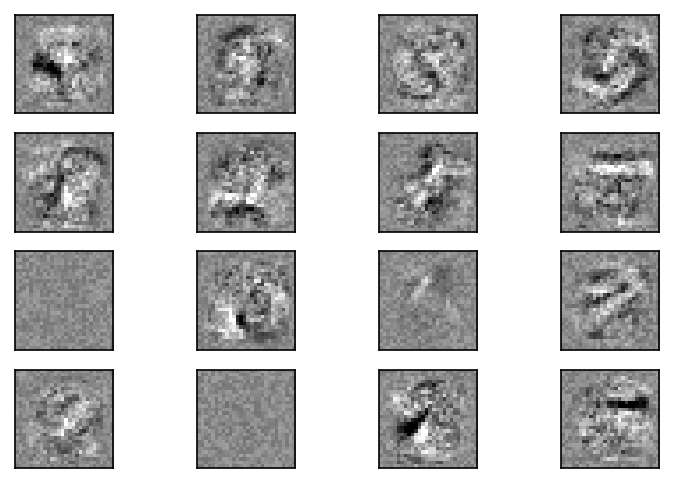

In [97]:
fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()